<a href="https://colab.research.google.com/github/sakshamgarg/Augmenting-Dirichlet-Network/blob/main/simclr_features/simclr_without_temp_scaling_m1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet
from mpl_toolkits import mplot3d

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc
from scipy.stats import multivariate_normal
from scipy.stats import norm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)                                             
cifar_transform =  transforms.Compose(
      [transforms.ToTensor(),
     transforms.Normalize(cifar_mean, cifar_std)])

In [3]:
train_in = torchvision.datasets.CIFAR10('./files/', train=True, download=True,
                                        transform=cifar_transform)
test_in = torchvision.datasets.CIFAR10('./files/', train=False, download=True,
                                        transform=cifar_transform)
train_out = torchvision.datasets.SVHN('./data', split ='train', download=True,
                                        transform=cifar_transform)
test_out = torchvision.datasets.SVHN('./data', split ='test', download=True,
                                        transform=cifar_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./files/cifar-10-python.tar.gz to ./files/
Files already downloaded and verified


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [4]:
train_out.data = np.vstack(train_out.data).reshape(-1, 32, 32, 3)

In [5]:
train_in.data = torch.from_numpy(train_in.data)
train_out.data = torch.from_numpy(train_out.data)

In [6]:
train_out.targets = torch.tensor(np.ones(len(train_out.labels))*10, dtype=torch.long)
test_out.targets = torch.tensor(np.ones(len(test_out.labels))*10, dtype=torch.long)

train_all = train_in
train_all.data = torch.cat((train_in.data, train_out.data))
train_all.targets = torch.cat((torch.IntTensor(np.array(train_in.targets)), torch.IntTensor(np.array(train_out.targets))))
train_all.data = train_all.data.cpu().detach().numpy()
train_all.targets = train_all.targets.data.cpu().detach().numpy()

In [7]:
train_loader = torch.utils.data.DataLoader(train_all, batch_size=64)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/My Drive/CV_Project

/content/drive/My Drive/CV_Project


In [10]:
! python resnet.py

In [11]:
from resnet import *

In [12]:
model = resnet18()

In [13]:
model.load_state_dict(torch.load('resnet18.pt'))

<All keys matched successfully>

In [14]:
class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        self.enc = base_encoder(pretrained=False)  # load model from torchvision.models without pretrained weights.
        self.feature_dim = self.enc.fc.in_features

        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3, and remove first max pooling.
        # See Section B.9 of SimCLR paper.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()  # remove final fully connected layer.

        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))

    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        return feature, projection

In [15]:
backbone = 'resnet18'
base_encoder = eval(backbone)
simclr_model = SimCLR(base_encoder, projection_dim=128)
simclr_model.load_state_dict(torch.load('simclr_resnet18_epoch1200.pt'))

<All keys matched successfully>

In [16]:
simclr_model = simclr_model.to(device)

In [17]:
def get_simclr_features(data, simclr_model):
    # print(data.shape)
    feature = simclr_model.enc(data)
    # print(feature.shape)
    # projection = simclr_model.projector(feature)
    return feature

In [18]:
def get_resnet_output(data,model):
  y = model.forward(data)
  y = torch.nn.functional.softmax(5*y, dim = 1)
  return y

In [19]:
model = model.to(device)
model = model.to(torch.float64)

In [20]:
model = model.type(torch.FloatTensor).to(device)
testdata = torchvision.datasets.CIFAR10('/files/', train=False, download=True,
                                        transform=cifar_transform)
testloader = torch.utils.data.DataLoader(testdata, batch_size=32)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /files/cifar-10-python.tar.gz to /files/


In [21]:
# RUN EVAL
model.eval()
correct = 0
total = 0
for data in testloader:
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    outputs = model(torch.autograd.Variable(inputs))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = correct / float(total)
print(accuracy)

tensor(0.9307, device='cuda:0')


In [22]:
# targets is a torch tensor of targets [3,4,5] for 3 in, [10,10,10] for 3 out, [3,10,1] in,out,im
def target_alpha(targets):
  target = targets.cpu().detach().numpy()
  def gen_onehot(category, total_cat=10):
    label = np.ones(total_cat)
    label[category] = 20
    return label
  target_alphas = []
  for i in target:
    if i==10:
      target_alphas.append(torch.tensor(np.ones(10)))
    else:
      target_alphas.append(torch.tensor(gen_onehot(i)))
  return torch.stack(target_alphas).to(device)

In [23]:
# 1 for out, -1 for in
def check_in_out_lambdas(target_alphas):

  alpha_sum = target_alphas.sum(axis = 1)
  alpha_sum = alpha_sum.cpu().detach()
  lambdas =  alpha_sum.apply_(lambda x: 1 if(x==10) else -1)
  return lambdas.to(device)


In [24]:
class PriorNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)         # output_dim = 4

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x #F.softmax(x, dim=1)

    def predict_alpha(self, x):
      src = torch.Tensor(x).to(device)
      output = torch.exp(self.forward(src))
      return output

    def predict_dir(self, x):
      alpha = self.predict_alpha(x)
      dirichlet = Dirichlet(alpha)
      return dirichlet

    def fit(self, epoch_num, optimizer, train_X, train_Y):
      self.train()

      n_train = len(train_X)

      # Shuffle the input
      index = np.arange(n_train)
      np.random.shuffle(index)
      train_x = train_X[index]
      train_y = train_Y[index]

      for epoch in range(epoch_num):
        for i in range(n_train):
          optimizer.zero_grad()
          src = torch.Tensor(train_x[i:i+1]).to(device)
          target = torch.Tensor(train_y[i:i+1]).to(device)
          # Predicted alpha
          output = torch.exp(self.forward(src))
          dirichlet1 = Dirichlet(output)
          dirichlet2 = Dirichlet(target)
          loss = dist.kl.kl_divergence(dirichlet1, dirichlet2)
          loss.backward()
          optimizer.step()
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss.item()))
    
    def expected_entropy_from_alphas(self, alphas, alpha0):
        return -torch.sum((alphas/alpha0)*(torch.digamma(alphas+1)-torch.digamma(alpha0+1)), dim=1)
    
    def categorical_entropy_torch(self, probs):
        log_probs = torch.log(probs)
        log_probs = torch.where(torch.isfinite(log_probs), log_probs, torch.zeros_like(log_probs))
        entropy = -torch.sum(probs*log_probs, dim=1, keepdim=False)
        return entropy

    def mutual_information(self, x):
        
        alphas = self.predict_alpha(x, model)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0

        expected_entropy = self.expected_entropy_from_alphas(alphas, alpha0)
        entropy_of_exp = self.categorical_entropy_torch(probs)
        mutual_info = entropy_of_exp - expected_entropy
        return mutual_info

    def diffenrential_entropy(self, x):
        alphas = self.predict_alpha(x, model)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        return torch.sum(
            torch.lgamma(alphas)-(alphas-1)*(torch.digamma(alphas)-torch.digamma(alpha0)),
            dim=1) - torch.lgamma(alpha0)

    def entropy(self, x):
        alphas = self.predict_alpha(x, model)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        ret = -torch.sum(probs*torch.log(probs), dim=1)
        return ret

In [25]:
augnet_path =  '/content/drive/MyDrive/CV_Project'
file_name = 'augnet_simclr_m1'
from os import truncate

class AugNet(PriorNet):

    def __init__(self, old_preds_dim, feature_dim, target_dim):
        super().__init__()
        self.y_dim = old_preds_dim
        self.feature_dim = feature_dim
        self.target_dim = target_dim
        self.fc1 = nn.Linear(feature_dim, 256)   
        self.relu = torch.nn.ReLU()
        self.fc2 = nn.Linear(256, 128)       
        self.fc3 = nn.Linear(128, 50) 
        self.fc4 = nn.Linear(50 + self.y_dim ,32) # concat # 50 + 10
        self.fc5 = nn.Linear(32,10)

     
  

    def forward(self, features, y):

      x = self.fc1(features)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      x = self.fc4(torch.cat( (y,x), dim = 1) )
      x = self.relu(x)
      x = self.fc5(x)

      return x



    def predict_alpha(self, x, model):
            x = torch.FloatTensor(x).unsqueeze(0) 
            x = x.to(device)
            x = x.reshape(-1, 3, 32, 32)
            features = get_simclr_features(x, simclr_model)
            pred_outputs = get_resnet_output(x, model)
#           src = torch.Tensor(x).to(device)
            output = torch.exp(self.forward(features, pred_outputs))
            return output
    def predict_dir(self, x):
      alpha = self.predict_alpha(x)
      dirichlet = Dirichlet(alpha)
      return dirichlet
  
    def fit(self, epoch_num, optimizer, model):
      self.train()
      loss_track = []
      # Shuffle the input
      train_loader = torch.utils.data.DataLoader(train_all, batch_size=64)

      for epoch in range(epoch_num):


        loss_total = 0
        for batch_idx, (data, target) in enumerate(train_loader):

          optimizer.zero_grad()
          target = target.to(device)
          data= data.type(torch.FloatTensor).to(device)
          features = get_simclr_features(data,simclr_model)
          features = features.detach().requires_grad_(False)
          y = get_resnet_output(data,model)
          y = y.detach().requires_grad_(False)

          # predict alpha
          target_a = target_alpha(target)
          target_a = target_a.to(device)
          out = self.forward(features, y)
          output_alpha = torch.exp(out)

          dirichlet1 = Dirichlet(output_alpha)
          dirichlet2 = Dirichlet(target_a)
          lambdas = check_in_out_lambdas(target_a)
          sgm_alpha = torch.sigmoid(output_alpha) 

          loss = torch.sum(dist.kl.kl_divergence(dirichlet1, dirichlet2)  + lambdas * torch.mean(sgm_alpha,1))
          loss_total += loss.item()
          loss.backward(retain_graph=True)
          optimizer.step()

        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss_total/120000))
        loss_track.append(loss_total)

        if(epoch%5 == 0):
        
          torch.save({
              'epoch': epoch,
              'model_state_dict': self.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss_track,
              }, f"{augnet_path}/{file_name+str(epoch)+'.pth'}")
        
      return loss_track
    
    def max_prob(self, x):
        alphas = self.predict_alpha(x, model)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        conf = torch.max(probs, dim=1)
        return conf.values

In [26]:
dpn = AugNet(10,512,10)
dpn.to(device)
optimizer = optim.Adam(dpn.parameters(), lr=0.001)

losses = dpn.fit(32, optimizer, model)

Train Epoch: 0 	 Loss: 2.081930
Train Epoch: 1 	 Loss: 0.533045
Train Epoch: 2 	 Loss: 0.574279
Train Epoch: 3 	 Loss: 0.406766
Train Epoch: 4 	 Loss: 0.427290
Train Epoch: 5 	 Loss: 0.314208
Train Epoch: 6 	 Loss: 0.308717
Train Epoch: 7 	 Loss: 0.376557
Train Epoch: 8 	 Loss: 0.381319
Train Epoch: 9 	 Loss: 0.369584
Train Epoch: 10 	 Loss: 0.469399
Train Epoch: 11 	 Loss: 0.362495
Train Epoch: 12 	 Loss: 0.385808
Train Epoch: 13 	 Loss: 0.377177
Train Epoch: 14 	 Loss: 0.395839
Train Epoch: 15 	 Loss: 0.456449
Train Epoch: 16 	 Loss: 0.438724
Train Epoch: 17 	 Loss: 0.395759
Train Epoch: 18 	 Loss: 0.476528
Train Epoch: 19 	 Loss: 0.409127
Train Epoch: 20 	 Loss: 0.449526
Train Epoch: 21 	 Loss: 0.424279
Train Epoch: 22 	 Loss: 0.440732
Train Epoch: 23 	 Loss: 0.459083
Train Epoch: 24 	 Loss: 0.421296
Train Epoch: 25 	 Loss: 0.487272
Train Epoch: 26 	 Loss: 0.530112
Train Epoch: 27 	 Loss: 0.474819
Train Epoch: 28 	 Loss: 0.555417
Train Epoch: 29 	 Loss: 0.618239
Train Epoch: 30 	 Lo

In [27]:
# miscood.py

def uncertainty_score(dpn, test_data, metrics):
  dpn.eval()
  score_lst = []
  for x in test_data:
    with torch.no_grad():
      if metrics=='DE':
        score = dpn.diffenrential_entropy(x).data.cpu().numpy()[0][0]
      elif metrics=='MI':
        score = dpn.mutual_information(x).data.cpu().numpy()[0]
      elif metrics=='MAXP':
        score = dpn.max_prob(x).data.cpu().numpy()[0]
      elif metrics=='ENT':
        score = dpn.entropy(x).data.cpu().numpy()[0]
    score_lst.append(score)
  return score_lst


def get_ood_label_score(test_in_score, test_out_score):
  score = np.concatenate([test_in_score, test_out_score])
  label = np.concatenate((np.zeros(len(test_in_score)), np.ones(len(test_out_score))))
  return label, score
  
def get_misc_label_score(dpn, test_data, test_label, test_in_score):
  misc_label = np.zeros(len(test_label))

  for i in range(len(test_data)):
    x = test_data[i]
#     x = [x]
    with torch.no_grad():
      pred = dpn.predict_alpha(x, model)
      pred_class = torch.max(pred[0], 0).indices
      misc_label[i] = 1-torch.eq(torch.tensor(test_label[i]), pred_class).sum().cpu().numpy()

  return misc_label, np.array(test_in_score)

def plot_roc(label, score, label_name):
  fpr, tpr, thresholds = roc_curve(label, score)
  plt.plot(fpr, tpr, label=label_name)
  plt.xlabel('False Positive')
  plt.ylabel('True Positive')
  plt.title('ROC')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)

def plot_pr(label, score, label_name):
  precision, recall, thresholds = precision_recall_curve(label, score)
  plt.plot(recall, precision, label=label_name)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)


def get_auroc_aupr(label, score):
  auroc = roc_auc_score(label, score)
  precision, recall, thresholds = precision_recall_curve(label, score)
  aupr = auc(recall, precision)
  return auroc, aupr


def get_test_roc_pr(network, metrics, detect='ood'):
  test_in_score = uncertainty_score(network, test_in.data, metrics)
  test_out_score = uncertainty_score(network, test_out.data, metrics)
  if detect=='ood':
    label_dp, score_dp = get_ood_label_score(test_in_score, test_out_score)
  elif detect=='misc':
    label_dp, score_dp = get_misc_label_score(network, test_in.data,
                                              test_in.targets, test_in_score)
  if metrics=='MAXP':
    score_dp = -score_dp

  index = np.isposinf(score_dp)
  score_dp[np.isposinf(score_dp)] = 1e9
  maximum = np.amax(score_dp)
  score_dp[np.isposinf(score_dp)] = maximum + 1

  index = np.isneginf(score_dp)
  score_dp[np.isneginf(score_dp)] = -1e9
  minimum = np.amin(score_dp)
  score_dp[np.isneginf(score_dp)] = minimum - 1

  score_dp[np.isnan(score_dp)] = 0

  auroc, aupr = get_auroc_aupr(label_dp, score_dp)
  return auroc, aupr, label_dp, score_dp

In [28]:
auroc_mp, aupr_mp, label_mp, score_mp = get_test_roc_pr(dpn, 'MAXP', 'misc')
auroc_ent, aupr_ent, label_ent, score_ent = get_test_roc_pr(dpn, 'ENT', 'misc')
auroc_mi, aupr_mi, label_mi, score_mi = get_test_roc_pr(dpn, 'MI', 'misc')
auroc_de, aupr_de, label_de, score_de = get_test_roc_pr(dpn, 'DE', 'misc')

In [29]:
auroc_lst = [auroc_mp, auroc_ent, auroc_mi, auroc_de]
aupr_lst = [aupr_mp, aupr_ent, aupr_mi, aupr_de]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.440935,0.439614,0.566764,0.437654
AUPR,0.885881,0.889155,0.918947,0.882349


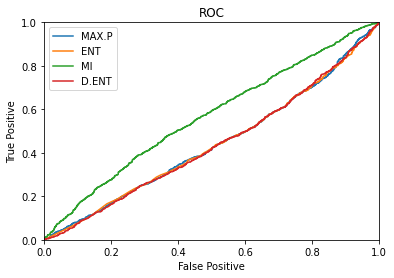

In [30]:
plot_roc(label_mp, score_mp, label_name='MAX.P')
plot_roc(label_ent, score_ent, label_name='ENT')
plot_roc(label_mi, score_mi, label_name='MI')
plot_roc(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

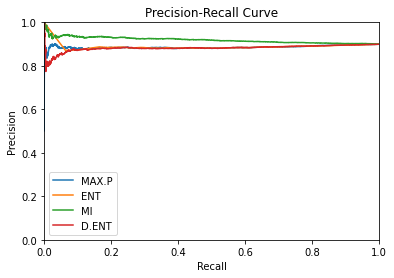

In [31]:
plot_pr(label_mp, score_mp, label_name='MAX.P')
plot_pr(label_ent, score_ent, label_name='ENT')
plot_pr(label_mi, score_mi, label_name='MI')
plot_pr(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

In [32]:
auroc_mp_ood, aupr_mp_ood, label_mp_ood, score_mp_ood = get_test_roc_pr(dpn, 'MAXP', 'ood')
auroc_ent_ood, aupr_ent_ood, label_ent_ood_ood, score_ent_ood = get_test_roc_pr(dpn, 'ENT', 'ood')
auroc_mi_ood, aupr_mi_ood_ood, label_mi_ood, score_mi_ood = get_test_roc_pr(dpn, 'MI', 'ood')
auroc_de_ood, aupr_de_ood, label_de_ood, score_de_ood = get_test_roc_pr(dpn, 'DE', 'ood')

In [33]:
auroc_lst_ood = [auroc_mp_ood, auroc_ent_ood, auroc_mi_ood, auroc_de_ood]
aupr_lst_ood = [aupr_mp_ood, aupr_ent_ood, aupr_mi_ood_ood, aupr_de_ood]

pd.DataFrame(data=np.array([auroc_lst_ood, aupr_lst_ood]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.774850,0.814970,0.211366,0.814694
AUPR,0.845201,0.869798,0.559768,0.889255


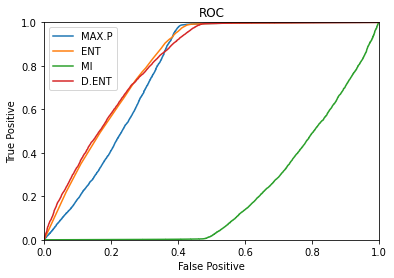

In [34]:
plot_roc(label_mp_ood, score_mp_ood, label_name='MAX.P')
plot_roc(label_ent_ood_ood, score_ent_ood, label_name='ENT')
plot_roc(label_mi_ood, score_mi_ood, label_name='MI')
plot_roc(label_de_ood, score_de_ood, label_name='D.ENT')
plt.legend()
plt.show()

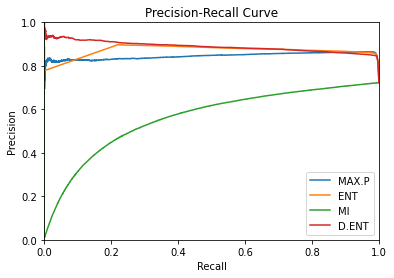

In [35]:
plot_pr(label_mp_ood, score_mp_ood, label_name='MAX.P')
plot_pr(label_ent_ood_ood, score_ent_ood, label_name='ENT')
plot_pr(label_mi_ood, score_mi_ood, label_name='MI')
plot_pr(label_de_ood, score_de_ood, label_name='D.ENT')
plt.legend()
plt.show()

In [36]:
# dnn = resnet18()
# dnn.load_state_dict(torch.load('resnet18.pt'))
# auroc_mp, aupr_mp, _, _ = get_test_roc_pr(dnn, 'MAXP', 'misc')
# auroc_ent, aupr_ent, _, _ = get_test_roc_pr(dnn, 'ENT', 'misc')

# auroc_lst = [auroc_mp, auroc_ent]
# aupr_lst = [aupr_mp, aupr_ent]

# pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
#              columns=['Max.P', 'Ent'], 
#              index=['AUROC', 'AUPR'])